## Simmulated annealing para planificación de trayectorias aéreas

- Catalina Lizana Guzmán

- Fabián C. Ulloa

 Para hacer un poco más realista el problema simularemos las trayectorias de múltiples aviones, pero estos llegaran a distintos aeropuertos que estarán ubicados en las siguientes posibles ubicaciones(aleatorias):

* $(x,y)\in [0,200]x[160,200] $
* $(x,y)\in [160,200]x[0,200] $


Para eso modificamos la función "crear_trayectoria" para que reciba un tercer parámetro que indicará el número de aeropuertos a los que llegaran los aviones y ubicaremos la mitad de estos en la parte superior del plano y la otra mitad en el costado derecho. Por último a cada avión le asignamos como punto final un aeropuerto aleatorio y discretizamos su trayectoria entre (0,0) y este punto de igual manera que en la parte anterior.

Para aplicar SA usamos las mismas funciones de la parte anterior, pues el procedimiento de detección de choques es el mismo.

Finalmente, analizaremos el número de interacciones en función de la cantidad de aeropuertos de llegada designados.

In [1]:
import numpy as np
import random
import time
import matplotlib.pyplot as plt
from matplotlib import animation

X = Y = 200 
T = 60
vel = 10 / 3  # 200 km/h es la vel de un avion comercial aprox.

def crear_trayectoria(n_tray,n_puntos):
    trayectories = []
    delta = X / n_puntos

    for i in range(n_tray):
        P = []
        x = 0
        y = 0
        t = np.random.randint(0, T)
        P.append([x, y, t]) 

        for k in range(n_puntos):
            x = np.random.uniform(delta*k, delta*(k+1))
            y = np.random.uniform(delta*k, delta*(k+1))
            # calcular t =dist/ vel
            a = np.array((x, y))
            b = np.array((P[k][0], P[k][1]))
            dist = np.linalg.norm(a-b)
            t = dist / vel + P[k][2]
            P.append([x, y, t])
        
        a = np.array((X, Y))
        b = np.array((P[n_puntos][0], P[n_puntos][1]))
        dist = np.linalg.norm(a-b)
        t = dist / vel + P[n_puntos][2]
        P.append([X, Y, t])
        P = np.array(P)
        trayectories.append(P)
    return trayectories

In [2]:
# Constantes a usar en el cálculo de la interacción.
d_x = d_y = int(X / 100)
d_t = 1
N_x = int(X / d_x) 
N_y = int(Y / d_y)
N_t = int(T / d_t)
# A la velocidad que van, en 30 segundos avanzan 5/3 [km].
N_h = 1.7
d_vec = 1.7 / np.sqrt(2)
t_eps = 1 / 2 

In [3]:
# Funciones para calcular la iteración.
def C(P, Q):
    """ Determina si los puntos P y Q están interactuando"""
    x = P[0] - Q[0]
    y = P[1] - Q[1]
    d_h = np.linalg.norm((x, y))       #Distancia 
    if np.abs(P[2] - Q[2]) < t_eps and d_h <= N_h:
        return 1
    else:
        return 0


def interaccion(tray, i, k):
    """ Calcula cuantos puntos interactuan en el punto k de la trayectoria i """
    suma = 0
    N=len(tray)
    for j in range(N):
        if j>i:
            for l in range(1,len(tray[j])-1):
                suma += C(tray[i][k], tray[j][l])  
    return suma


def Interacciones(trayectorias):
    """ Calcula el total de puntos interactuando dada una distribución de trayectorias"""
    phi = 0
    N = len(trayectorias)
    for i in range(N):
        for k in range(i, len(trayectorias[i])-1):
            phi += interaccion(trayectorias, i, k)    
    return phi
  

# El siguiente algoritmo para calcular lo anterior es más eficiente.
def interaccion_por_grilla(tray):
    cas_x = []
    cas_y = []
    cas_t = []

    # Creamos más casillas de las "necesarias" con tal de que no exista
    # error al momento de hacer la iteración.
    for x in range(N_x + 10):
        cas_x.append([])
    for y in range(N_y + 10):
        cas_y.append([])
    # A priori debiesemos calcular el maximo tiempo en la trayectoria, pero la cota 3*N_t es lo suficientemente grande.
    for t in range(3 * N_t):
        cas_t.append([])
         
    phi = 0
    
    for t in tray:
        for P in t[1:-1]:
            n_x = int(P[0] / d_x)
            n_y = int(P[1] / d_y)
            n_t = int(P[2] / d_t)
            
            # Veo si en las casillas adjuntas hay algun punto cerca.
            for i in range(-1, 2):
                for j in range(-1, 2):
                    for k in range(-1, 2):
                        if len(cas_x[n_x + i])>0 and len(cas_y[n_y + j])>0 and len(cas_t[n_t + k])>0:
                            for Q in cas_x[n_x + i]:
                                if (Q in cas_y[n_y + j]) and (Q in cas_t[n_t + k]):
                                    phi += C(P,Q)

            cas_x[n_x].append(list(P))
            cas_y[n_y].append(list(P))
            cas_t[n_t].append(list(P))
    
    return phi

In [4]:
# Funciones para crear un vecino.

def cambio_tiempos(T,i):
    """ Dado una trayectoria T con un punto i cambiado, se calculan los cambios en los tiempos"""
    T1 = T.copy()
    tiempo = T1[i-1][2]

    for k in range(i,len(T)):
        a=T1[k-1][0:2]
        b=T1[k][0:2]
        dist = np.linalg.norm(a-b)
        T1[k][2] = dist / vel + tiempo
        tiempo=T1[k][2]
    return T1

def neighborhood(trayectorias):
    t = trayectorias.copy()
    new_1 = new_2 = -1
    while new_1 > X or 0 > new_1 or new_2 > Y or 0 > new_2 :
        i = np.random.randint(0, len(trayectorias))
        new_t = t[i]
        j = np.random.randint(1, len(new_t)-1)
        new_1 = new_t[j][0] + np.random.uniform(-d_vec, d_vec)
        new_2 = new_t[j][1] + np.random.uniform(-d_vec, d_vec)
    
    
    new_t[j][0] = new_1
    new_t[j][1] = new_2
    cambio_tiempos(new_t,j)
    t[i] = cambio_tiempos(new_t,j)
    return t

In [5]:
# Sucesiones beta a utilizar.

# beta_n polinomico.
def beta_cuad(n):
    return n ** (2)

# beta_n exponencial.
def beta_exp(n):
    return 3 ** n

# beta_n lineal.
def beta_lin(n):
    return 2 * n

In [6]:
# Algoritmo SA.

def CM(t, func_beta, trayectorias):
    """
    Simula la cadena hasta tiempo t
    func_beta es la función que da el valor de beta
    según cada iteración
    """
    X = []
    X.append(trayectorias) 
    u = np.random.uniform(0,1,t)
    
    for n in range(t):
        beta = func_beta(n)
        Y = neighborhood(X[n])
        cte_n = np.min((1, np.exp(float(-beta * (interaccion_por_grilla(Y) - interaccion_por_grilla(X[n]))))))
        
        if u[n] < cte_n:
            X.append(Y)
        else:
            X.append(X[n])
            
    return X

In [7]:
# Calcular el tiempo de ejecución.
def timeSince(since):
    now = time.time_ns()
    s = now - since
    return s * 10**(-9)

###

In [8]:
# Crear trayectorias .
# Aeropuertos en cualquier parte.

import numpy as np
import random
import matplotlib.pyplot as plt


X = Y = 200
T = 60
vel = 10 / 3
def crear_trayectoria2(n_tray,n_puntos,n_aeropuertos):
    trayectories = []
    
    aeropuertos=[]
    for a in range(n_aeropuertos):
        if a<n_aeropuertos/2:
            x=np.random.randint(0.8*X,X)
            y=np.random.randint(0,Y)
            aeropuertos.append([x,y])
        else:
            x=np.random.randint(0,X)
            y=np.random.randint(0.8*Y,Y)
            aeropuertos.append([x,y])
        

    for i in range(n_tray):
        ae=np.random.randint(0,n_aeropuertos)
        x_fin=aeropuertos[ae][0]
        y_fin=aeropuertos[ae][1]
        
        delta_x =  x_fin/ n_puntos
        delta_y =  y_fin/ n_puntos
        
        delta_t = int(T / n_puntos)
        
        P = []
        x = 0
        y = 0
        t = np.random.randint(0, T)
        P.append([x, y, t]) 
        

        for k in range(n_puntos):
            
            x = np.random.uniform(delta_x*k, delta_x*(k+1))
            y = np.random.uniform(delta_y*k, delta_y*(k+1))
            # Calcular t = dist/ vel.
            a = np.array((x, y))
            b = np.array((P[k][0], P[k][1]))
            dist = np.linalg.norm(a-b)
            t = dist / vel + P[k][2]
            P.append([x, y, t])
            
        a = np.array((x_fin, y_fin))
        b = np.array((P[n_puntos][0], P[n_puntos][1]))
        dist = np.linalg.norm(a-b)
        t = dist / vel + P[n_puntos][2]
        P.append([x_fin, y_fin, t])
        P = np.array(P)
        trayectories.append(P)
    return trayectories

193


(0.0, 200.0)

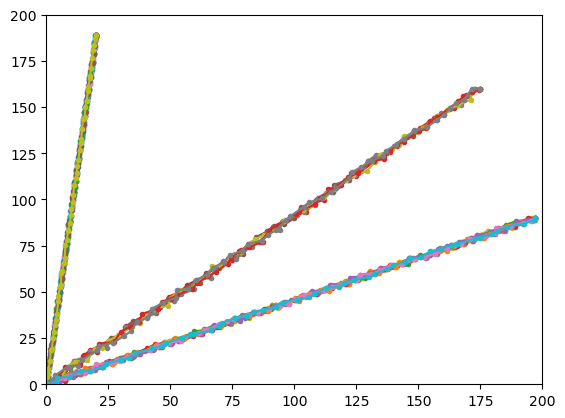

In [9]:
trayec = crear_trayectoria2(30, 50, 3)

print(interaccion_por_grilla(trayec))

for P in trayec:
    plt.plot(P[:,0], P[:,1], ".-")
plt.xlim(0,200)
plt.ylim(0,200)


C:\Users\nico_\AppData\Local\Temp\ipykernel_2016\3401157527.py:16: RuntimeWarning: overflow encountered in exp
  cte_n = np.min((1, np.exp(float(-beta * (interaccion_por_grilla(Y) - interaccion_por_grilla(X[n]))))))


120


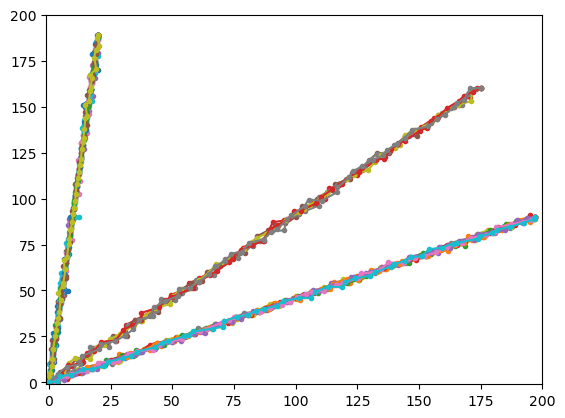

In [10]:
Fin=CM(400,beta_exp,trayec)[-1]

print(interaccion_por_grilla(Fin))

for k in Fin:
    plt.plot(k[:,0], k[:,1], ".-")
plt.xlim(-1,200)
plt.ylim(-1,200)
plt.show()

In [11]:
aeropuertos= np.linspace(10 ,60, 6) 
inter_i=[]

inter_f=[]

for i in aeropuertos:
    trayec=crear_trayectoria2(60,50, int(i))
    inter_i.append(interaccion_por_grilla(trayec))
    
    Fin=CM(200,beta_exp,trayec)[-1]
    inter_f.append(interaccion_por_grilla(Fin))


C:\Users\nico_\AppData\Local\Temp\ipykernel_2016\3401157527.py:16: RuntimeWarning: overflow encountered in exp
  cte_n = np.min((1, np.exp(float(-beta * (interaccion_por_grilla(Y) - interaccion_por_grilla(X[n]))))))


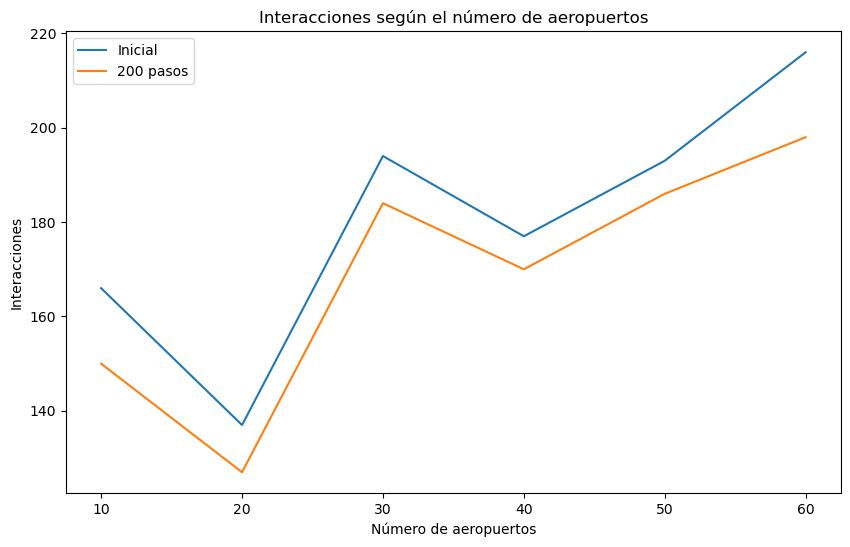

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(aeropuertos,inter_i, label="Inicial")

plt.plot(aeropuertos,inter_f, label="200 pasos")

plt.title("Interacciones según el número de aeropuertos")
plt.xlabel("Número de aeropuertos")
plt.ylabel("Interacciones")
plt.legend()
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=47c70f3e-dd89-48de-a308-e52c5c3a84e4' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>